<a href="https://colab.research.google.com/github/Gurpreet654/Multi-interactive-Dual-decoder/blob/master/Training_MMIDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/MIDD/working_MIDD_CODES2'

Mounted at /content/drive
/content/drive/MyDrive/MIDD/working_MIDD_CODES2


Import libraries 

In [ ]:
%cd '/content/drive/MyDrive/MIDD/working_MIDD_CODES2'
coding='utf-8'
import os
from net2 import Mnet
import torch
import random
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from lib.dataset import Data
from lib.data_prefetcher import DataPrefetcher
from torch.nn import functional as F
# from smooth_loss import get_saliency_smoothness
# import floss
# from floss import DiceLoss
import matplotlib.pyplot as plt
import torch as nn
from itertools import compress
from keras.metrics import MeanIoU

/content/drive/MyDrive/MIDD/working_MIDD_CODES2


Number of pixels for each class, Class 0(c0) is background, c1 AN, c2 CO, c3 HO

In [ ]:
print('whole datatset')
print('co',c0)
print('c1',c1)
print('c2',c2)
print('c3',c3)
print('percentage c0',(c0/(c0+c1+c2+c3)).round(decimals=2))
print('percentage c1',(c1/(c0+c1+c2+c3)).round(decimals=2))
print('percentage c2',(c2/(c0+c1+c2+c3)).round(decimals=2))
print('percentage c3',(c3/(c0+c1+c2+c3)).round(decimals=2))

whole datatset
co 231491270
c1 4316206
c2 3529607
c3 10305925
percentage c0 0.93
percentage c1 0.02
percentage c2 0.01
percentage c3 0.04


In [ ]:
print('Training datatset')
print('co',c0)
print('c1',c1)
print('c2',c2)
print('c3',c3)
print('percentage c0',(c0/(c0+c1+c2+c3)).round(decimals=3))
print('percentage c1',(c1/(c0+c1+c2+c3)).round(decimals=3))
print('percentage c2',(c2/(c0+c1+c2+c3)).round(decimals=3))
print('percentage c3',(c3/(c0+c1+c2+c3)).round(decimals=3))

Training datatset
co 137329392
c1 4245755
c2 3208290
c3 10045363
percentage c0 0.887
percentage c1 0.027
percentage c2 0.021
percentage c3 0.065


visulisation of weights

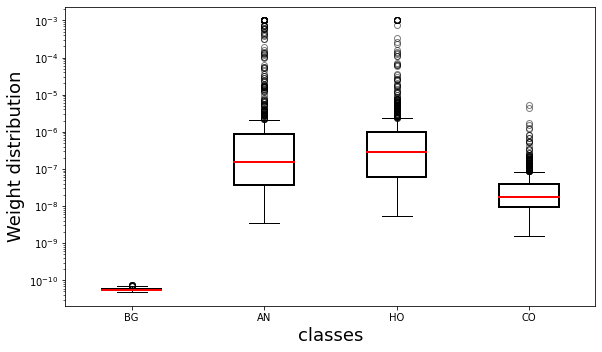

In [ ]:
# from matplotlib.pyplot import figure
# # figure(figsize=(20, 8), dpi=80)
# green_diamond = dict(markerfacecolor='r', marker='o')
# fig1, ax1 = plt.subplots()
# ax1.boxplot(pjj2[:,:])
# ax1.set_yscale('logit')
labels = ['BG', 'AN', 'HO','CO']
fig = plt.figure()
# fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.set_size_inches(9.5, 5.5)
lipo=ax.boxplot(pjj2[:,:],patch_artist=True,labels=labels)
colors = ['white','white','white','white']
for bplot in (lipo,lipo):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set(linewidth = 2)
for median in lipo['medians']:
    median.set(color ='red',
               linewidth = 2)
ax.set_yscale('log')
# ax.legend(['','','','','','median','outlier'])
# ax.set_title('axes title')
ax.set_xlabel('classes',fontsize=18)
ax.set_ylabel('Weight distribution',fontsize=18)
for flier in lipo['fliers']:
    flier.set(marker ='o',
              color ='#e7298a',
              alpha = 0.5)
# for cap in lipo['caps']:
#     cap.set(color ='#8B008B',
#             linewidth = 2)
# plt.se

Data Prepration, images with high bacground pixels were eliminated


In [ ]:
import cv2
root='/content/drive/MyDrive/MIDD/working_MIDD_CODES2/DataSet/Sub_GT3'
li = os.listdir(root)
# li=li[0:10]
kl=[]
kl1=[]
for i in li:
  a=cv2.imread(os.path.join(root, i),0)
  # _, _, values, _= cv2.connectedComponentsWithStats(a,8,cv2.CV_32S)
  values=(a==0).sum()
  kl.append(values)
  kl1.append(i)
kl1kl=zip(kl,kl1)
sspl=sorted(kl1kl)
pp=(np.array([sspl]))
pp1=list(pp[0,:5800,1])
pp3=list(pp[0,4060:,1])

shuffle the training and testing data

In [ ]:
import random
random.shuffle(train_setup)
random.shuffle(test_setup)

In [ ]:
!pip install -U segmentation-models-pytorch
import segmentation_models_pytorch as smp
from sklearn.metrics import accuracy_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 5.0 MB/s 
     |████████████████████████████████| 376 kB 27.7 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=22380e4fa3e8dafc0673577e55c22e4b2922c1773271d089f2cf043f504ad86c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=06ea1b8ed8b46494a66ae7f0c71937506c6d0106094441d6315bb0be17682090
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!pip install segmentation-models
import segmentation_models as sm

Defineing Loss function

In [ ]:
def soft_dice_scoree(output,target):
    bs = target.size(0)
    num_classes = target.size(1)
    dims = (0, 2)
    assert output.size() == target.size()
    target = target.view(bs, num_classes, -1)
    # output=F.softmax(output,1)
    output = output.view(bs, num_classes, -1)
    counts = torch.sum(target, axis=2)
    smooth=1e-7
    weight=1/(((torch.sum(counts,0))**2+smooth))
    # weight=weight[1:]
    # output=output[:,1:,:]
    # target=target[:,1:,:]
    # weight[0]=weight[0]/1000
    # weight[1]=weight[1]*1000
    # weight[2]=17.6820
    # weight[3]=6.0558
    # 0.26960305, 14.45963237, 17.68206829,  6.05581275
    # weight=torch.tensor([ 4.035644846168807e-17/1.6381407574797816e-13,1.0954677375030047e-13/1.6381407574797816e-13,1.6381407574797816e-13/1.6381407574797816e-13,9.415123884871382e-17/1.6381407574797816e-13]).to('cuda')
    # weight[0]=0
    # weight/=weight
    # smooth=0.0001
    eps: float = 1e-7
    # target=target
    # if dims is not None:
    intersection = torch.sum(weight*torch.sum(output * target, dim=(2)),1)
                  # torch.sum(weight*torch.sum(target1 * output1, dim=(2)),1)
    # cardinality = torch.sum(weight*torch.sum(output**2 + target**2, dim=(2)),1)
    cardinality = torch.sum(weight*torch.sum(output + target, dim=(2)),1)
    dice_score = ((2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps))
    
    loss = 1.0 - dice_score

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

    # mask = target.sum(dims) > 0
    # loss *= mask.to(loss.dtype)
    # print(weight)
    
    return loss.mean(),weight

    # return dice_score

  

Training

In [ ]:
# modified MIDD

if __name__ == '__main__':
    random.seed(118)
    np.random.seed(118)
    torch.manual_seed(118)
    torch.cuda.manual_seed(118)
    torch.cuda.manual_seed_all(118)
    pp2=pp1
    img_root=pp2
    # img_root1=pp3
    save_path = './model'
    if not os.path.exists(save_path): os.mkdir(save_path)
    lr = 0.001
    batch_size = 4
    epoch = 50
    lr_dec=[21,51]
    
    #%%
    # img_root = '/content/drive/MyDrive/MIDD/working_MIDD_CODES2/DataSet'
    pp2=pp1
    #%%
    data = Data(pp2)
    # ttrain1, validd = random_split(data,[5420,1352])  #GT_Sub3
    # data1=Data(img_root1)
    # ttrain =data1
    ttrain,test1 = random_split(data,[int(np.floor(0.7*(len(data)))),(int(len(data)-np.floor(0.7*(len(data)))))])
    # data1=Data(test_setup)
    data1=test1
    ttest,validd=random_split(data1,[600,900])
    # ttest,validd=random_split(data1,[int(np.floor(0.5*(len(data1)))),(int(len(data1)-np.floor(0.5*(len(data1)))))])
    loader = DataLoader(ttrain, batch_size=batch_size, shuffle=True, num_workers=1)
    loader_V=DataLoader(validd, batch_size=batch_size, shuffle=True, num_workers=1)
    #%%
    net = Mnet().cuda()
    #%%
    net.load_pretrained_modell()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay=0.0005,momentum=0.9)
    # Dd=smp.losses.DiceLoss('multilabel')
    iter_num = len(loader)
    iter_num_k = len(loader_V)
    loss,lossf,lossf_V,loss1,loss2=([] for i in range(5))
    loss1_V,loss2_V,loss_V,lossg,lossg_V=([] for i in range(5))
    overall_accuracy,overall_accuracy_V,accuracy=([] for i in range(3))
    n_classes = 4
    
    net.train()
    class0_IoU,class1_IoU,class2_IoU,class3_IoU=([] for i in range(4))
    class0_IoU_V,class1_IoU_V,class2_IoU_V,class3_IoU_V=([] for i in range(4))
    val_t,val_v,iou_scoret,f1_scoret,f2_scoret,recallt,Precisiont=([] for i in range(7))

    recallt0,recallt1,recallt2,recallt3=([] for i in range(4))
    
#%%
    for epochi in range(0, epoch):
        if epochi in lr_dec :
            lr=lr/10
            optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, weight_decay=0.0005,momentum=0.9)
            print(lr)
        prefetcher = DataPrefetcher(loader)
        rgb, t, label,glabel = prefetcher.next()        
        r_sal_loss,sal_loss1_,sal_loss2_,sal_loss3_,sal_loss1V_,sal_loss2V_,sal_loss3V_,sal_lossg_,sal_lossgV_=(0 for i in range(9))
        r_sal_loss_V,total_size,correct,total_size_V,correct_V,iou_score,f1_score,f2_score,recall,Precision=(0 for i in range(10))
        recall0,recall1,recall2,recall3=(0 for i in range(4))
        IOU_keras = MeanIoU(num_classes=n_classes) 
        values=np.zeros((4,4))
        net.zero_grad()
        i = 0
        for i in range(0, iter_num):
            i+=1
            # rgb=rgb.cpu()
            # t=t.cpu()
            optimizer.zero_grad()
            score, g= net(rgb.float(), t.float())
            sal_loss1=soft_dice_scoree(score,label)
            label_g = F.interpolate(glabel, g.shape[2:], mode='nearest')
            Dl=smp.losses.DiceLoss("binary")
            sal_lossg=Dl(g,label_g)
            sal_loss=(sal_loss1+sal_lossg)/2
            r_sal_loss += sal_loss.data
            sal_loss1_+=sal_loss1.data
            sal_lossg_+=sal_lossg.data
            sal_loss.backward()
            optimizer.step()
            score_acc=torch.argmax(score,dim=1)         
            label_acc1=torch.argmax(label,dim=1)
            correct += (score_acc == label_acc1).float().sum()
            # correct+=(score_acc[0]==label_acc1[0]).sum()+(score_acc[1]==label_acc1[1]).sum()+(score_acc[2]==label_acc1[2]).sum()+(score_acc[3]==label_acc1[3]).sum()
            total_size+=label_acc1.cpu().numpy().size
            IOU_keras.update_state(score_acc.cpu(), label_acc1.cpu())
            values += np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
            
            tp, fp, fn, tn = smp.metrics.get_stats(score.round().long(), label.round().long(), mode='multilabel', threshold=None)
            # then compute metrics with required reduction (see metric docs)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            f1_score += smp.metrics.f1_score(tp, fp, fn, tn, reduction="macro")
            f2_score += smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="macro")
            # accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            recall += smp.metrics.recall(tp, fp, fn, tn, reduction="macro")
            Precision += smp.metrics.precision(tp, fp, fn, tn, reduction="macro")
            
            tp1, fp1, fn1, tn1 = smp.metrics.get_stats(((score.round())[:,0,:,:]).long(), label[:,0,:,:].round().long(), mode='binary', threshold=None)
            recall0 += smp.metrics.fbeta_score(tp1, fp1, fn1, tn1,beta=2, reduction="macro")
            tp1, fp1, fn1, tn1 = smp.metrics.get_stats(((score.round())[:,1,:,:]).long(), label[:,1,:,:].round().long(), mode='binary', threshold=None)
            recall1 += smp.metrics.fbeta_score(tp1, fp1, fn1, tn1,beta=2, reduction="macro")
            tp1, fp1, fn1, tn1 = smp.metrics.get_stats(((score.round())[:,2,:,:]).long(), label[:,2,:,:].round().long(), mode='binary', threshold=None)
            recall2 += smp.metrics.fbeta_score(tp1, fp1, fn1, tn1,beta=2, reduction="macro")
            tp1, fp1, fn1, tn1 = smp.metrics.get_stats(((score.round())[:,3,:,:]).long(), label[:,3,:,:].round().long(), mode='binary', threshold=None)
            recall3 += smp.metrics.fbeta_score(tp1, fp1, fn1, tn1,beta=2, reduction="macro")
            

            if i % len(loader) == 0:
                print('epoch: [%2d/%2d], iter: [%5d/%5d]  ||  loss : %5.4f || accuracy : %5.2f ' % (
                    epochi, epoch, i, iter_num, r_sal_loss / i,100*correct/total_size))
                print(sal_lossg_/i)
                # r_sal_loss = 0
            rgb, t, label,glabel = prefetcher.next()
          #validation

        loss.append(r_sal_loss.cpu().numpy()/len(loader))
        lossf.append(sal_loss1_.cpu().numpy()/len(loader))
        lossg.append(sal_lossg_.cpu().numpy()/len(loader))
        
        overall_accuracy.append(100*correct.cpu().numpy()/total_size)
        val_t.append(values)
        class0_IoU.append(values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0]))
        class1_IoU.append(values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1]))
        print(class1_IoU,class0_IoU)
        print(iou_score/iter_num,f1_score/iter_num,Precision/iter_num,recall/iter_num)
        class2_IoU.append(values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2]))
        class3_IoU.append(values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3]))

        iou_scoret.append(iou_score.cpu().numpy()/iter_num)
        f1_scoret.append(f1_score.cpu().numpy()/iter_num)
        f2_scoret.append(f2_score.cpu().numpy()/iter_num)
        Precisiont.append(Precision.cpu().numpy()/iter_num)
        recallt.append(recall.cpu().numpy()/iter_num)

        recallt0.append(recall0.cpu().numpy()/iter_num)
        recallt1.append(recall1.cpu().numpy()/iter_num)
        recallt2.append(recall2.cpu().numpy()/iter_num)
        recallt3.append(recall3.cpu().numpy()/iter_num)
        
        prefetcher_V = DataPrefetcher(loader_V)
        rgb, t, label,glabel = prefetcher_V.next()
        net.eval()
        # print(correct_V,total_size_V)
        IOU_keras = MeanIoU(num_classes=n_classes) 
        
        values_V=np.zeros((4,4))
        k=0
        
        

        for k in range(0,iter_num_k):
            k+=1
            score,g= net(rgb.float(), t.float())
            label_g = F.interpolate(glabel, g.shape[2:], mode='nearest')
            sal_loss1_V=soft_dice_scoree(score,label)
            Dl=smp.losses.DiceLoss("binary")
            sal_lossg_V=Dl(g,label_g)
            sal_loss=(sal_loss1_V+sal_lossg_V)/2
            # r_sal_loss += sal_loss.data
            r_sal_loss_V += sal_loss.data
            score_acc=torch.argmax(score,dim=1)         
            label_acc1=torch.argmax(label,dim=1)
            total_size_V+=label_acc1.cpu().numpy().size
            correct_V += (score_acc == label_acc1).float().sum()
            sal_loss1V_+=sal_loss1_V.data
            sal_lossgV_+=sal_lossg_V.data
            IOU_keras.update_state(score_acc.cpu(), label_acc1.cpu())
            values_V += np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
            # print(correct,total_size)
            if k % iter_num_k == 0:
                print(loss,loss_V,lossf,loss1,loss2,lossf_V,loss1_V,loss2_V,overall_accuracy,overall_accuracy_V)
                print('epoch: [%2d/%2d], iter: [%5d/%5d]  ||  loss : %5.4f || accuracy_Val: %5.2f' % (
                    epochi, epoch, k, iter_num_k, r_sal_loss_V / 100,100*correct_V/total_size_V))
                print(sal_lossg_/k)
            rgb, t, label,glabel = prefetcher_V.next()  
        # loss_V.append(r_sal_loss_V/len(loader_V))
        loss_V.append(r_sal_loss_V.cpu().numpy()/len(loader_V))
        lossf_V.append(sal_loss1V_.cpu().numpy()/len(loader_V))
        # loss1_V.append(sal_loss2V_.cpu().numpy()/len(loader_V))
        # loss2_V.append(sal_loss3V_.cpu().numpy()/len(loader_V))
        lossg_V.append(sal_lossgV_.cpu().numpy()/len(loader_V))
        overall_accuracy_V.append(100*correct_V.cpu().numpy()/total_size_V)
        val_v.append(values_V)
        class0_IoU_V.append(values_V[0,0]/(values_V[0,0] + values_V[0,1] + values_V[0,2] + values_V[0,3] + values_V[1,0]+ values_V[2,0]+ values_V[3,0]))
        class1_IoU_V.append(values_V[1,1]/(values_V[1,1] + values_V[1,0] + values_V[1,2] + values_V[1,3] + values_V[0,1]+ values_V[2,1]+ values_V[3,1]))
        print(class1_IoU_V)
        class2_IoU_V.append(values_V[2,2]/(values_V[2,2] + values_V[2,0] + values_V[2,1] + values_V[2,3] + values_V[0,2]+ values_V[1,2]+ values_V[3,2]))
        class3_IoU_V.append(values_V[3,3]/(values_V[3,3] + values_V[3,0] + values_V[3,1] + values_V[3,2] + values_V[0,3]+ values_V[1,3]+ values_V[2,3]))
        net.train()

        if loss[epochi] <= 0.08:

          torch.save(net.state_dict(), '%s/early_stop58_wg_M%d.pth' % (save_path, epochi))
          print("early stoping")
          break
        
        torch.save(net.state_dict(), '%s/final_batch1_try58wg_M.pth' % (save_path))

        #34 was with very high weightage
                

In [ ]:
a1*

array([[1810.61, 1796.89, 1794.21, ..., 1714.29, 1741.77, 1788.25],
       [1836.73, 1811.45, 1798.53, ..., 1707.13, 1778.01, 1778.01],
       [1851.21, 1826.25, 1800.41, ..., 1704.45, 1742.21, 1819.33],
       ...,
       [1615.61, 1619.65, 1621.77, ..., 1518.25, 1468.25, 1468.25],
       [1617.57, 1610.09, 1619.61, ..., 1457.13, 1472.89, 1399.81],
       [1600.25, 1610.09, 1588.29, ..., 1457.13, 1408.49, 1386.09]])

In [ ]:
print(loss,loss_V,lossf,loss1,loss2,lossf_V,loss1_V,loss2_V,overall_accuracy,overall_accuracy_V)

[0.9160907617531967, 0.8530255137717703, 0.8286503113977073, 0.8039382853835979, 0.7679843801669973, 0.6546381121169532, 0.571393425081983, 0.483646022789903, 0.44408571488853066, 0.4135135872654183, 0.39606845862440754, 0.3726535104149443, 0.3590267659074625, 0.36879847289393186, 0.351637798221864, 0.33547922501067845, 0.3216009930538332, 0.32019134467661486, 0.30540627777261076, 0.30454836783165234, 0.3051950498443011, 0.29071814589189265, 0.283839338460717, 0.2771816085465581, 0.28167062587838954, 0.2625557228370949, 0.27077644253954475, 0.27131198028618275, 0.2735737526437803, 0.2662070945457176] [0.8746547154017857, 0.8562462942940848, 0.8221202850341797, 0.8039161137172154, 0.742567879813058, 0.6445600237165179, 0.5859678540910993, 0.5268464769635882, 0.5071947915213448, 0.5073861803327288, 0.47754358564104354, 0.46096829005650114, 0.4743709019252232, 0.4366649900163923, 0.46481388636997767, 0.4337687083653041, 0.4373117446899414, 0.41821438925606863, 0.40330979483468193, 0.42624

Text(0.5, 0, 'epochs')

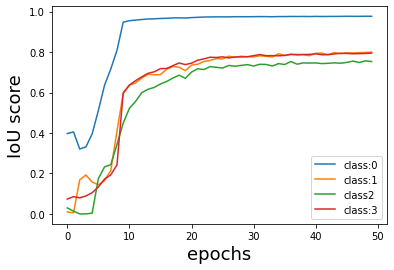

In [ ]:
plt.plot(class0_IoU)
plt.plot(class1_IoU)
plt.plot(class2_IoU)
plt.plot(class3_IoU)
plt.legend(["class:0","class:1","class2","class:3"])
plt.ylabel('IoU score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

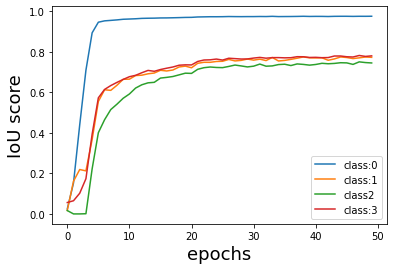

In [ ]:
#MI
plt.plot(class0_IoU)
plt.plot(class1_IoU)
plt.plot(class2_IoU)
plt.plot(class3_IoU)
plt.legend(["class:0","class:1","class2","class:3"])
plt.ylabel('IoU score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

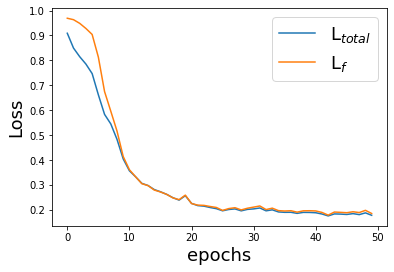

In [ ]:
# plt.plot(loss1)
# plt.plot(loss2)
plt.plot(loss)
plt.plot(lossf)
# plt.legend(['L$_{rgb}$','L$_t$','L$_f$'],fontsize=18)
plt.legend(['L$_{total}$','L$_f$'],fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('epochs',fontsize=18)
# plt.plot(loss)


Text(0.5, 0, 'epochs')

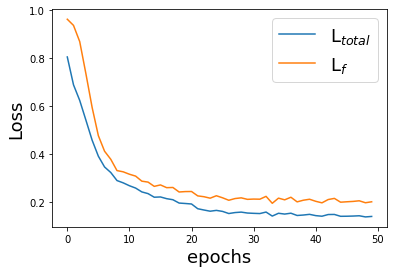

In [ ]:
#MI
# plt.plot(loss1)
# plt.plot(loss2)
plt.plot(loss)
plt.plot(lossf)
# plt.legend(['L$_{rgb}$','L$_t$','L$_f$'],fontsize=18)
plt.legend(['L$_{total}$','L$_f$'],fontsize=18)
plt.ylabel('Loss',fontsize=18)
plt.xlabel('epochs',fontsize=18)
# plt.plot(loss)


Text(0.5, 0, 'epochs')

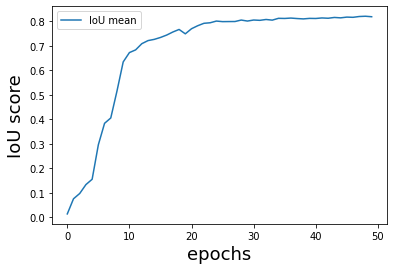

In [ ]:
plt.plot(iou_scoret)
# ii=(np.array(class0_IoU)+np.array(class1_IoU)+np.array(class2_IoU)+np.array(class3_IoU))/4
plt.legend(["IoU mean"])
plt.ylabel('IoU score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

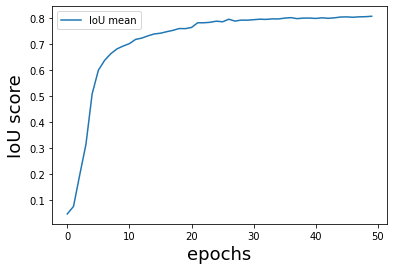

In [ ]:
#MI
plt.plot(iou_scoret)
# ii=(np.array(class0_IoU)+np.array(class1_IoU)+np.array(class2_IoU)+np.array(class3_IoU))/4
plt.legend(["IoU mean"])
plt.ylabel('IoU score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

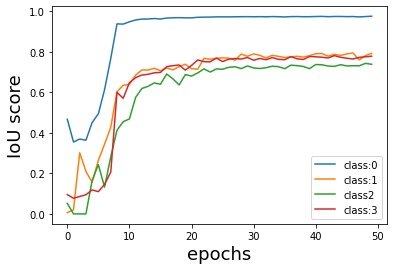

In [ ]:
plt.plot(class0_IoU_V)
plt.plot(class1_IoU_V)
plt.plot(class2_IoU_V)
plt.plot(class3_IoU_V)
plt.legend(["class:0","class:1","class2","class:3"])
plt.ylabel('IoU score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

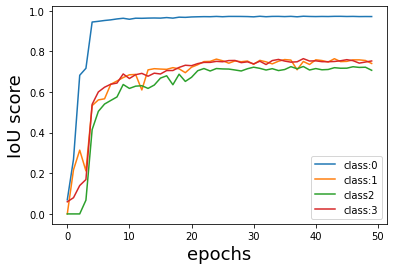

In [ ]:
#MI
plt.plot(class0_IoU_V)
plt.plot(class1_IoU_V)
plt.plot(class2_IoU_V)
plt.plot(class3_IoU_V)
plt.legend(["class:0","class:1","class2","class:3"])
plt.ylabel('IoU score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

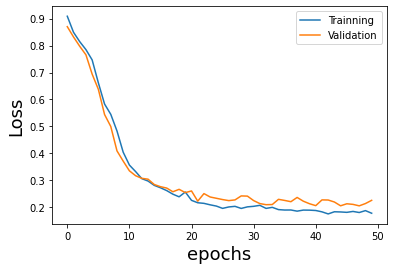

In [ ]:
plt.plot(loss)
plt.plot(loss_V)
plt.legend(["Trainning","Validation"])
plt.ylabel('Loss',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

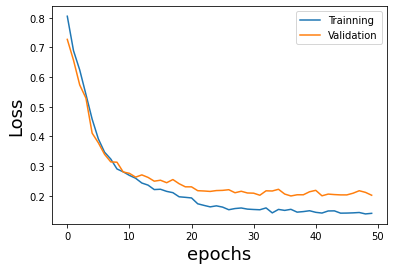

In [ ]:
#MI
plt.plot(loss)
plt.plot(loss_V)
plt.legend(["Trainning","Validation"])
plt.ylabel('Loss',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

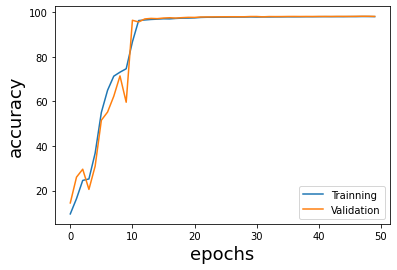

In [ ]:
plt.plot(overall_accuracy)
plt.plot(overall_accuracy_V)
plt.legend(["Trainning","Validation"])
plt.ylabel('accuracy',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

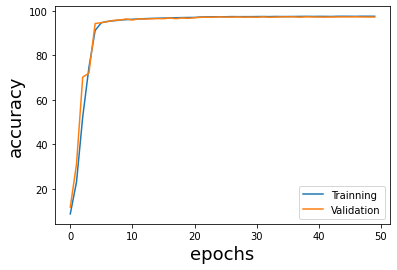

In [ ]:
#MI
plt.plot(overall_accuracy)
plt.plot(overall_accuracy_V)
plt.legend(["Trainning","Validation"])
plt.ylabel('accuracy',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

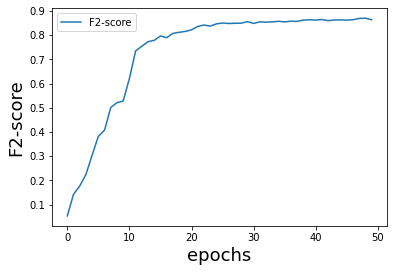

In [ ]:
# plt.plot(f1_scoret)
plt.plot(f2_scoret)
plt.legend(['F2-score'])
plt.ylabel('F2-score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

Text(0.5, 0, 'epochs')

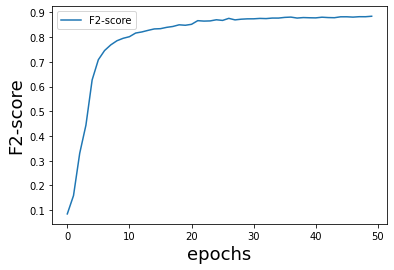

In [ ]:
#MI
# plt.plot(f1_scoret)
plt.plot(f2_scoret)
plt.legend(['F2-score'])
plt.ylabel('F2-score',fontsize=18)
plt.xlabel('epochs',fontsize=18)

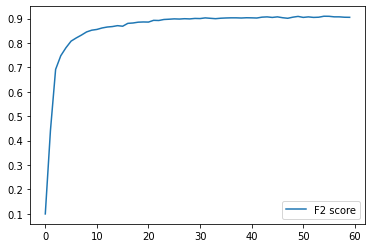

In [ ]:
plt.plot(f2_scoret)
plt.legend(['F2 score'])

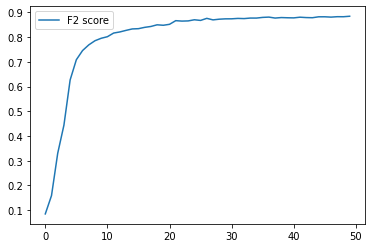

In [ ]:
#MI
plt.plot(f2_scoret)
plt.legend(['F2 score'])

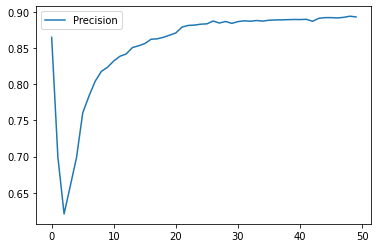

In [ ]:
plt.plot(Precisiont)
plt.legend(['Precision'])

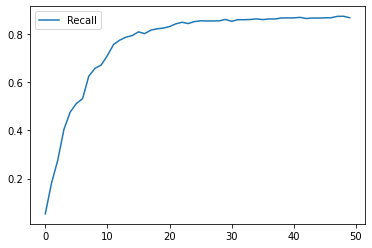

In [ ]:
plt.plot(recallt)
plt.legend(['Recall'])

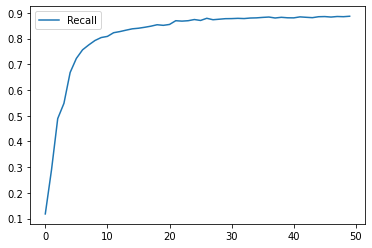

In [ ]:
#MI
plt.plot(recallt)
plt.legend(['Recall'])

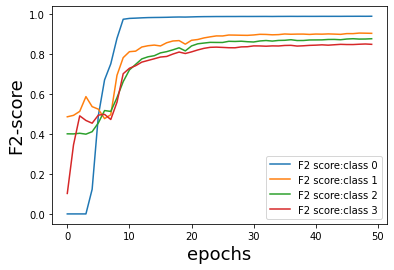

In [ ]:
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=80)
plt.plot(recallt0)
plt.plot(recallt1)
# xx=(np.array(recallt1)+np.array(recallt0)+np.array(recallt3))/3
plt.plot(recallt2)
plt.plot(recallt3)
plt.ylabel('F2-score',fontsize=18)
plt.xlabel('epochs',fontsize=18)
plt.legend(['F2 score:class 0','F2 score:class 1','F2 score:class 2','F2 score:class 3'])
# plt.show(figsize=(10,6))


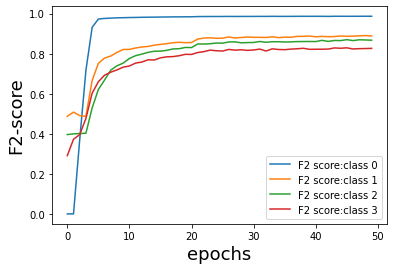

In [ ]:
#MI
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=80)
plt.plot(recallt0)
plt.plot(recallt1)
# xx=(np.array(recallt1)+np.array(recallt0)+np.array(recallt3))/3
plt.plot(recallt2)
plt.plot(recallt3)
plt.ylabel('F2-score',fontsize=18)
plt.xlabel('epochs',fontsize=18)
plt.legend(['F2 score:class 0','F2 score:class 1','F2 score:class 2','F2 score:class 3'])
# plt.show(figsize=(10,6))


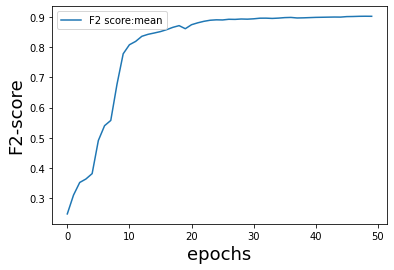

In [ ]:
plt.plot((np.array(recallt1)+np.array(recallt0)+np.array(recallt2)+np.array(recallt3))/4)
plt.ylabel('F2-score',fontsize=18)
plt.xlabel('epochs',fontsize=18)
plt.legend(['F2 score:mean'])

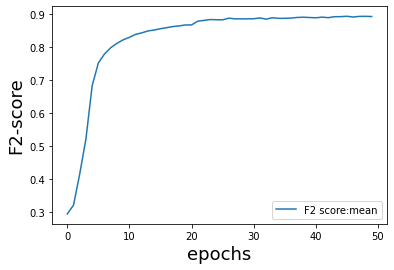

In [ ]:
#MI
plt.plot((np.array(recallt1)+np.array(recallt0)+np.array(recallt2)+np.array(recallt3))/4)
plt.ylabel('F2-score',fontsize=18)
plt.xlabel('epochs',fontsize=18)
plt.legend(['F2 score:mean'])